In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss
from torch.nn.utils.rnn import pad_sequence
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset, random_split
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
!pip install livelossplot
from livelossplot import PlotLosses
from tqdm import tqdm

data = pd.read_parquet('/kaggle/input/resume-features-cleaned/resume-features.parquet', columns=['Category', 'cleaned_resumes'])

In [4]:
#  ────────────────────────────────────────────────────────────────────
#   CPU VS GPU                                                         
#  ────────────────────────────────────────────────────────────────────
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device('cpu')
print("Using {}.".format(device))

Using cuda.


In [13]:
#  ────────────────────────────────────────────────────────────────────
#   DATASET                                                            
#  ────────────────────────────────────────────────────────────────────
def tokenization(texts, tokenizer_type='basic_english', specials=['<unk>'], device=device):
    tokenizer = get_tokenizer(tokenizer_type)
    tokens = [tokenizer(text) for text in texts]
    vocab = build_vocab_from_iterator(tokens, specials=specials)
    vocab.set_default_index(vocab['<unk>'])

    tokenized_texts = [torch.tensor([vocab[token] for token in text], dtype=torch.int64, device=device) for text in tokens]

    return tokenized_texts, vocab

class ResumeDataset(Dataset):
    def __init__(self, data, device=device):
        super().__init__()
        self.text = data.iloc[:,1]
        self.labels = torch.tensor(data.iloc[:,0], device=device)
        
        self.tokenized_texts, self.vocab = tokenization(self.text, device=device)

    def __len__(self):
        return len(self.labels)

    def vocab_size(self):
        return len(self.vocab)

    def num_class(self):
        return len(self.labels.unique())

    def __getitem__(self, idx):
        sequence = self.tokenized_texts[idx]
        label = self.labels[idx]
        return sequence, label

def collate_fn(batch, device=device):
    sequences, labels = zip(*batch)
    sequences_padded = pad_sequence(sequences, batch_first=True, padding_value=0)
    labels = torch.tensor(labels, dtype=torch.long, device=device)
    return sequences_padded, labels

dataset = ResumeDataset(data)
train_dataset, val_dataset, test_dataset = random_split(dataset, [0.7, 0.15, 0.15])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)

In [81]:
class SimpleNN(nn.Module):
    def __init__(self, vocab_size, embed_size, num_class, expansion_factor=2, dropout=0.1):
        super().__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_size, sparse=False)
        self.hidden_dim = embed_size * expansion_factor
        self.layer1 = nn.Linear(embed_size, self.hidden_dim)
        self.layer2 = nn.Linear(self.hidden_dim, embed_size)
        self.layer3 = nn.Linear(embed_size, num_class)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        x = F.relu(self.layer1(x))
        x = self.dropout(x)
        x = F.relu(self.layer2(x))
        x = self.dropout(x)
        x = self.layer3(x)
        return x

In [71]:
def train_model(model, train_loader, val_loader, epochs, criterion, optimizer, scheduler=None, visualize=None, device=device, save=None):
    """
    This function trains a PyTorch model using the given data loaders and hyperparameters.
    The function also supports visualization using liveloss or matplotlib.

    Parameters:
    - model: object: A PyTorch model object.
    - train_loader: DataLoader: A DataLoader object containing the training data.
    - val_loader: DataLoader: A DataLoader object containing the validation data.
    - criterion: object: A loss function object.
    - optimizer: object: An optimizer object.
    - epochs: int: The number of epochs to train the model.
    - scheduler: object: A learning rate scheduler object.
    - visualize: str: A string that determines the visualization method. Choose from [None, 'liveloss', 'matplotlib'].
    - save_path: str: A string containing the path to save the best model.

    Returns:
    Model performance metrics and visualization.
    """
    best_val_loss = float('inf')
    best_val_accuracy = float('inf')
    best_model_wts = None
    
    assert visualize in [None, 'liveloss', 'matplotlib'], "Invalid visualization method. Choose from [None, 'liveloss', 'matplotlib']."

    if visualize == 'liveloss':
        liveloss = PlotLosses()

    if visualize == 'matplotlib':
        train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")

        # Training Phase
        logs = {}
        model.train()
        train_loss, train_corrects, train_total = 0.0, 0, 0

        for data, labels in tqdm(train_loader, desc="Training", leave=False):
            data, labels = data.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * data.size(0)
            _, preds = torch.max(outputs, 1)
            train_corrects += torch.sum(preds == labels.data)
            train_total += data.size(0)

        train_loss /= len(train_loader.dataset)
        train_accuracy = train_corrects.double() / train_total

        model.eval()
        val_loss, val_corrects, val_total = 0.0, 0, 0

        with torch.no_grad():
            for data, labels in tqdm(val_loader, desc="Validation", leave=False):
                data, labels = data.to(device), labels.to(device)

                outputs = model(data)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * data.size(0)
                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data)
                val_total += data.size(0)

        val_loss /= len(val_loader.dataset)
        val_accuracy = val_corrects.double() / val_total

        if visualize != 'liveloss':
            print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy:.4f}")
            print(f"  Val Loss: {val_loss:.4f} |   Val Acc: {val_accuracy:.4f}")

        if scheduler.__class__.__name__ == 'ReduceLROnPlateau':
            scheduler.step(val_loss)
        else:
            scheduler.step()

        # Save logs for visualization
        if visualize == 'liveloss':
            logs['log loss'] = train_loss
            logs['accuracy'] = train_accuracy.item()
            logs['val_log loss'] = val_loss
            logs['val_accuracy'] = val_accuracy.item()
            liveloss.update(logs)
            liveloss.send()
        elif visualize == 'matplotlib':
            train_losses.append(train_loss)
            train_accuracies.append(train_accuracy.cpu())  # Move to CPU
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy.cpu())  # Move to CPU

        # Check if current model is the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_val_accuracy = val_accuracy
            best_model_wts = model.state_dict().copy()
            print(f"👉 New best model with val loss: {val_loss:.4f}!")

        print("-" * 30)

    # Save best model
    if save and best_model_wts:
        torch.save(best_model_wts, save)
        print(f"Best model saved:")
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy:.4f}")

    # Plot in matplotlib
    if visualize == 'matplotlib':
        plt.figure(figsize=(10, 5))

        # Plot training and validation losses
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss')
        plt.legend()

        # Plot training and validation accuracies
        plt.subplot(1, 2, 2)
        plt.plot(train_accuracies, label='Training Accuracy')
        plt.plot(val_accuracies, label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.show()

    print("✅ Training complete!")

def test_model(model, test_loader, criterion, device=device):
    """
    This function tests a PyTorch model using the given data loader and loss function.

    Parameters:
    - model: object: A PyTorch model object.
    - test_loader: DataLoader: A DataLoader object containing the testing data.
    - criterion: object: A loss function object.

    Returns:
    Model performance metrics.
    """
    model.eval()
    test_loss, test_corrects, test_total = 0.0, 0, 0

    with torch.no_grad():
        for data, labels in tqdm(test_loader, desc="Testing", leave=False):
            data, labels = data.to(device), labels.to(device)

            outputs = model(data)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * data.size(0)
            _, preds = torch.max(outputs, 1)
            test_corrects += torch.sum(preds == labels.data)
            test_total += data.size(0)

    test_loss /= len(test_loader.dataset)
    test_accuracy = test_corrects.double() / test_total

    print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_accuracy:.4f}")
    print("✅ Testing complete!")

    return test_loss, test_accuracy


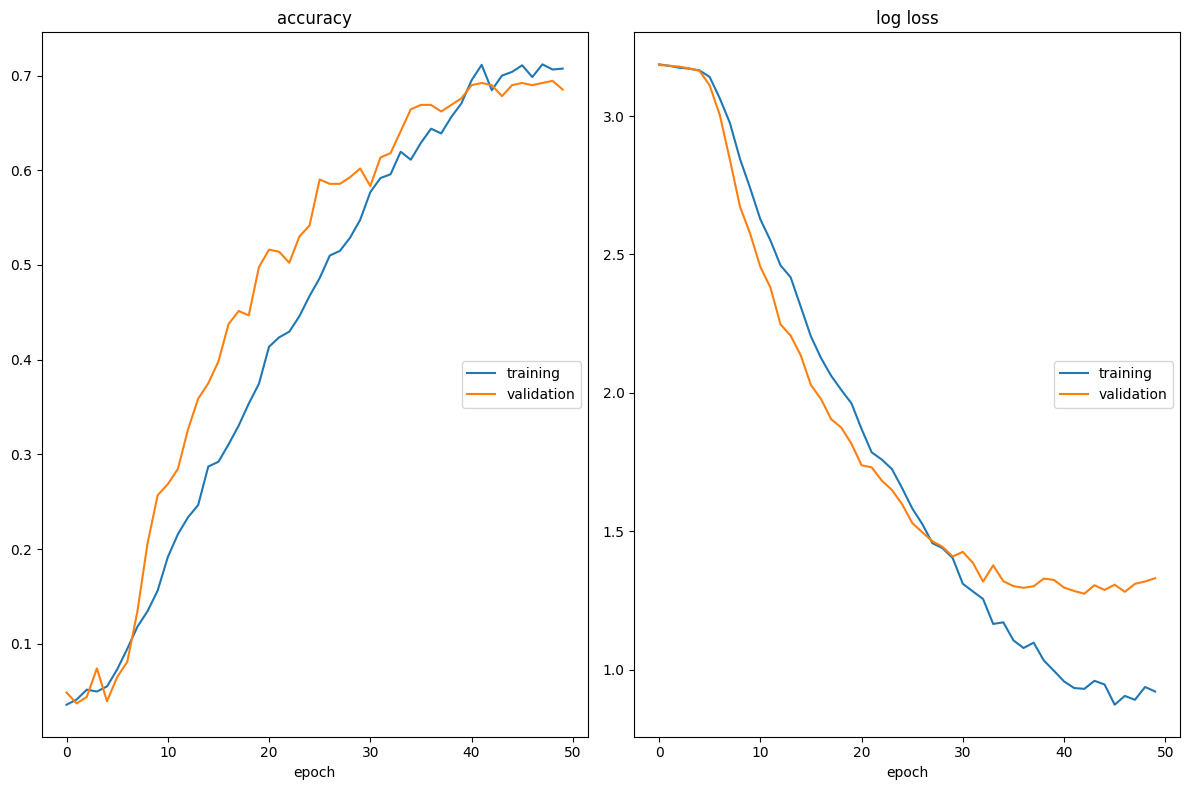

accuracy
	training         	 (min:    0.036, max:    0.712, cur:    0.707)
	validation       	 (min:    0.037, max:    0.694, cur:    0.685)
log loss
	training         	 (min:    0.873, max:    3.187, cur:    0.921)
	validation       	 (min:    1.274, max:    3.184, cur:    1.330)
------------------------------
Best model saved:
Val Loss: 1.3300 | Val Acc: 0.6852
✅ Training complete!


In [96]:
#  ────────────────────────────────────────────────────────────────────
#   HYPERPARAMETERS                                                    
#  ────────────────────────────────────────────────────────────────────
vocab_size = dataset.vocab_size()
num_class = dataset.num_class()
embed_size = 60
lr=0.001
epochs = 50

model = SimpleNN(vocab_size, embed_size, num_class, dropout=0.5).to(device)
criterion = CrossEntropyLoss()
loss = Adam(model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(loss, patience=2)

train_model(model, train_loader, val_loader, epochs, criterion, loss, scheduler, visualize='liveloss', save='nn-model.pth.gz')

In [97]:
accuracy = test_model(model, test_loader, criterion)

Test Loss: 1.1444 | Test Acc: 0.7315
✅ Testing complete!
